In [1]:
# run in a notebook cell with `!` or in terminal
!pip install datasets tqdm



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\yrsee\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\importlib\__init__.py:126: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  return _bootstrap._gcd_import(name[level:], package, level)


Total FairFace rows: 86744
Columns: ['image', 'age', 'gender', 'race', 'service_test']
Example keys: ['image', 'age', 'gender', 'race', 'service_test']
Race label example: 0


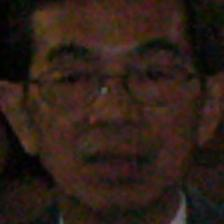

In [2]:
# Load FairFace (choose config '0.25' or '1.25'; 0.25 is smaller & faster)
from datasets import load_dataset

# use '0.25' for a smaller/fast copy (good for notebooks)
ds = load_dataset("HuggingFaceM4/FairFace", "0.25", split="train")

print("Total FairFace rows:", len(ds))
print("Columns:", ds.column_names)

# preview one record (image will be a PIL.Image or numpy array)
rec = ds[0]
print("Example keys:", list(rec.keys()))
print("Race label example:", rec.get('race'))
display(rec.get('image'))


In [3]:
# Cell 2: wrap HuggingFace dataset in a PyTorch Dataset for training
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import numpy as np

# mapping: FairFace race labels are strings -> create numeric mapping
RACE_ORDER = ["White","Black","Indian","East Asian","Southeast Asian","Middle Eastern","Latino"]  # 7 classes

transform_train = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    # light color jitter OK for pretraining; keep modest
    T.ColorJitter(0.1,0.1,0.05,0.02),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
transform_val = T.Compose([T.Resize((224,224)), T.ToTensor(),
                           T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

class FairFaceTorch(Dataset):
    def __init__(self, hf_dataset, split='train', transform=None):
        self.ds = hf_dataset
        self.transform = transform
        self.r2i = {r:i for i,r in enumerate(RACE_ORDER)}
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        rec = self.ds[idx]
        img = rec['image'] if isinstance(rec['image'], Image.Image) else Image.fromarray(rec['image'])
        if self.transform: img = self.transform(img)
        race = rec['race']
        lbl = self.r2i.get(race, -1)
        return img, torch.tensor(lbl, dtype=torch.long)

# create torch datasets (you can split ds into train/val if needed; here we use ds for training sample)
ff_ds = FairFaceTorch(ds, transform=transform_train)
# small smoke-check
img, lbl = ff_ds[0]
print("sample img", img.shape, "label", lbl)


sample img torch.Size([3, 224, 224]) label tensor(-1)


In [4]:
# DIAG: inspect FairFace race values and first few batch label ranges
from collections import Counter
import torch
from torch.utils.data import DataLoader

# If you hit a CUDA assert earlier, restart the kernel now, then run this cell.
print("Dataset length (hf ds):", len(ds))
# show unique races (hf datasets has a convenient method)
try:
    unique_races = ds.unique("race")
except Exception:
    # fallback for some versions / streaming datasets
    unique_races = sorted(list({rec['race'] for rec in ds}))
print("Unique race values (sample):", unique_races[:40])
print("Count unique:", len(unique_races))

# Check mapping you use (RACE_ORDER)
print("RACE_ORDER mapping:", RACE_ORDER)

# Check if any dataset rows have race not in mapping
bad_count = 0
bad_examples = []
for i in range(min(len(ds), 5000)):   # sample first 5k to be quick
    r = ds[i]['race']
    if r not in RACE_ORDER:
        bad_count += 1
        if len(bad_examples) < 10:
            bad_examples.append((i, r))
print("Rows with race not in RACE_ORDER (sampled):", bad_count)
print("Examples:", bad_examples)

# Create your torch dataset wrapper (same as before) *but do not start training*
ff_ds = FairFaceTorch(ds, transform=transform_train)
print("Torch dataset length:", len(ff_ds))

# Inspect labels from a small DataLoader batch (no GPU)
ld = DataLoader(ff_ds, batch_size=64, shuffle=False, num_workers=0)
first = next(iter(ld))
imgs, labels = first
print("labels dtype:", labels.dtype, "min/max:", labels.min().item(), labels.max().item())
print("labels unique counts (first batch):", Counter(labels.tolist()))

# Full dataset label min/max scan (safe CPU)
all_min = 999; all_max = -999; bad_count = 0
for i in range(len(ff_ds)):
    _, lbl = ff_ds[i]
    v = int(lbl.item())
    if v < all_min: all_min = v
    if v > all_max: all_max = v
    if v < 0 or v >= len(RACE_ORDER):
        bad_count += 1
        if bad_count <= 10:
            print("Bad label at idx", i, "label:", v, "race string:", ds[i]['race'])
print("All labels min/max:", all_min, all_max, "bad_count (out-of-range):", bad_count)


Dataset length (hf ds): 86744
Unique race values (sample): [0, 1, 2, 3, 4, 5, 6]
Count unique: 7
RACE_ORDER mapping: ['White', 'Black', 'Indian', 'East Asian', 'Southeast Asian', 'Middle Eastern', 'Latino']
Rows with race not in RACE_ORDER (sampled): 5000
Examples: [(0, 0), (1, 1), (2, 2), (3, 1), (4, 1), (5, 3), (6, 4), (7, 1), (8, 3), (9, 4)]
Torch dataset length: 86744
labels dtype: torch.int64 min/max: -1 -1
labels unique counts (first batch): Counter({-1: 64})
Bad label at idx 0 label: -1 race string: 0
Bad label at idx 1 label: -1 race string: 1
Bad label at idx 2 label: -1 race string: 2
Bad label at idx 3 label: -1 race string: 1
Bad label at idx 4 label: -1 race string: 1
Bad label at idx 5 label: -1 race string: 3
Bad label at idx 6 label: -1 race string: 4
Bad label at idx 7 label: -1 race string: 1
Bad label at idx 8 label: -1 race string: 3
Bad label at idx 9 label: -1 race string: 4
All labels min/max: -1 -1 bad_count (out-of-range): 86744


In [5]:
# Inspect dataset
print("ds type:", type(ds))
# show a few top-level properties
try:
    print("Column names:", ds.column_names)
except Exception as e:
    print("Could not read ds.column_names:", e)
# show a few example records
for i in range(3):
    rec = ds[i]
    print(f"rec[{i}] keys:", list(rec.keys()), "race:", rec.get("race"))


ds type: <class 'datasets.arrow_dataset.Dataset'>
Column names: ['image', 'age', 'gender', 'race', 'service_test']
rec[0] keys: ['image', 'age', 'gender', 'race', 'service_test'] race: 0
rec[1] keys: ['image', 'age', 'gender', 'race', 'service_test'] race: 1
rec[2] keys: ['image', 'age', 'gender', 'race', 'service_test'] race: 2


In [7]:
# Robust handling for FairFace 'race' being either ClassLabel (ints) or strings.
from datasets import Dataset, ClassLabel
from collections import Counter
from PIL import Image
import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
from torchvision import transforms as T
import time

# 1) Inspect the 'race' feature type and mapping (if any)
race_feat = None
try:
    race_feat = ds.features['race']
    print("ds.features['race'] type:", type(race_feat))
    if isinstance(race_feat, ClassLabel):
        print("Race is ClassLabel with names:", race_feat.names, "num_classes:", len(race_feat.names))
        race_names = race_feat.names
        class_is_label = True
    else:
        # not ClassLabel — values may be strings or ints depending on config
        # inspect a few raw values
        sample_vals = [ds[i]['race'] for i in range(min(10, len(ds)))]
        print("Sample ds['race'] values (first 10):", sample_vals)
        # detect if they are ints
        if all(isinstance(v, int) for v in sample_vals):
            print("Race values are integers already (assume 0..C-1).")
            class_is_label = True
            # We'll try to infer names if available (some configs keep names in metadata)
            race_names = None
        else:
            print("Race values look like strings. will treat as strings.")
            class_is_label = False
            race_names = None
except Exception as e:
    print("Could not inspect ds.features['race']:", e)
    class_is_label = False
    race_names = None

# 2) Build ds_labeled robustly
if class_is_label:
    # If ClassLabel object present, keep numeric labels as-is.
    # If race values are ints but names unknown, still use the ints as labels.
    def add_label_int(example):
        # ensure label is int
        example['label'] = int(example['race'])
        return example
    ds_labeled = ds.map(add_label_int, batched=False)
else:
    # race appears to be strings; build mapping from observed names
    # collect unique race strings (sample up to N)
    unique = sorted(list({ds[i]['race'] for i in range(min(len(ds), 10000))}))
    print("Observed race strings (sample up to 10):", unique[:10])
    # if you want a canonical order, define it here; otherwise create one from observed values
    # canonical_order = ["White","Black","Indian","East Asian","Southeast Asian","Middle Eastern","Latino"]
    canonical_order = unique  # fallback
    r2i = {r:i for i,r in enumerate(canonical_order)}
    def add_label_str(example):
        example['label'] = r2i.get(example['race'], -1)
        return example
    ds_filtered = ds.filter(lambda rec: rec['race'] in r2i)
    ds_labeled = ds_filtered.map(add_label_str, batched=False)

# 3) Verify new column exists and label stats
print("After mapping, columns:", ds_labeled.column_names)
# sample label counts (fast sample)
n = min(5000, len(ds_labeled))
labels_sample = [int(ds_labeled[i]['label']) for i in range(n)]
print("Sampled label stats: total_sampled=", len(labels_sample), "unique=", sorted(set(labels_sample)))
print("Counts (sample):", dict(Counter(labels_sample)))

# 4) Torch Dataset wrapper that uses 'label' and safe image conversion
transform_train = T.Compose([T.Resize((224,224)), T.RandomHorizontalFlip(),
                             T.ColorJitter(0.1,0.1,0.05,0.02),
                             T.ToTensor(),
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

class FairFaceTorchSafe(TorchDataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        rec = self.ds[int(idx)]
        img = rec['image']
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        lbl = int(rec['label'])
        return img, torch.tensor(lbl, dtype=torch.long)

ff_ds_safe = FairFaceTorchSafe(ds_labeled, transform=transform_train)
print("Created ff_ds_safe length:", len(ff_ds_safe))

# 5) One-epoch smoke training loop to confirm no device-side assert
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = DataLoader(ff_ds_safe, batch_size=128, shuffle=True, num_workers=0, pin_memory=(device.type=='cuda'))
import torchvision.models as models, torch.nn as nn, torch.optim as optim
model_test = models.resnet18(pretrained=True)
in_f = model_test.fc.in_features
# set output classes to number of unique labels observed
num_classes = len(set(labels_sample)) if len(set(labels_sample))>0 else (len(race_names) if race_names else 7)
print("Using num_classes =", num_classes)
model_test.fc = nn.Linear(in_f, num_classes)
model_test = model_test.to(device)

optim_test = optim.AdamW(model_test.parameters(), lr=3e-4)
crit = nn.CrossEntropyLoss()

print("Running a single-epoch smoke test (will stop early after a few batches)...")
model_test.train()
t0 = time.time()
bcount = 0
try:
    for imgs, labels in loader:
        imgs = imgs.to(device); labels = labels.to(device)
        optim_test.zero_grad()
        out = model_test(imgs)
        loss = crit(out, labels)
        loss.backward()
        optim_test.step()
        bcount += 1
        if bcount >= 6:
            break
    print("Smoke run succeeded: ran", bcount, "batches in", time.time()-t0, "s")
except Exception as e:
    print("Smoke run failed with exception:", repr(e))
    import traceback; traceback.print_exc()
    print("If this is a CUDA device-side assert, restart the kernel and run again.")


ds.features['race'] type: <class 'datasets.features.features.ClassLabel'>
Race is ClassLabel with names: ['East Asian', 'Indian', 'Black', 'White', 'Middle Eastern', 'Latino_Hispanic', 'Southeast Asian'] num_classes: 7
After mapping, columns: ['image', 'age', 'gender', 'race', 'service_test', 'label']
Sampled label stats: total_sampled= 5000 unique= [0, 1, 2, 3, 4, 5, 6]
Counts (sample): {0: 672, 1: 711, 2: 764, 3: 972, 4: 491, 5: 809, 6: 581}
Created ff_ds_safe length: 86744
Using num_classes = 7
Running a single-epoch smoke test (will stop early after a few batches)...
Smoke run succeeded: ran 6 batches in 5.905799865722656 s


In [8]:
# 1) FULL LABEL AUDIT (CPU-only) - run after kernel restart
from collections import Counter
import numpy as np

assert 'ds_labeled' in globals(), "ds_labeled not found — re-run mapping cell that created ds_labeled."

# compute stats
n = len(ds_labeled)
mins = 10**9
maxs = -10**9
bad = []
counts = Counter()
for i in range(n):
    lbl = ds_labeled[i].get('label')
    # protect against missing
    if lbl is None:
        bad.append((i, 'MISSING'))
        continue
    try:
        v = int(lbl)
    except Exception as e:
        bad.append((i, f'NONINT:{lbl}'))
        continue
    counts[v] += 1
    if v < mins: mins = v
    if v > maxs: maxs = v
    if v < 0:
        bad.append((i, v))
    # optional: if you expect C classes, check upper bound later

print("Total rows:", n)
print("Label min:", mins, "max:", maxs)
print("Unique labels (sampled):", sorted(list(counts.keys())))
print("Counts (first 10):", dict(list(counts.items())[:10]))
print("Bad examples found (first 20):", bad[:20])
# if you have an expected number of classes, print it:
if 'race_names' in globals() and race_names:
    print("Expected classes (race_names length):", len(race_names))


Total rows: 86744
Label min: 0 max: 6
Unique labels (sampled): [0, 1, 2, 3, 4, 5, 6]
Counts (first 10): {0: 12287, 1: 12319, 2: 12233, 3: 16527, 4: 9216, 5: 13367, 6: 10795}
Bad examples found (first 20): []
Expected classes (race_names length): 7


In [9]:
# 2) Build safe Torch dataset and check batches (CPU only)
from PIL import Image
import torch
from torch.utils.data import DataLoader

class FairFaceTorchSafeCPU(torch.utils.data.Dataset):
    def __init__(self, hfds, transform=None):
        self.ds = hfds
        self.transform = transform
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        rec = self.ds[int(idx)]
        img = rec['image']
        if not isinstance(img, Image.Image):
            from PIL import Image as PILImage
            img = PILImage.fromarray(img)
        if self.transform:
            img = self.transform(img)
        lbl = rec.get('label')
        return img, lbl

# simple no-normalize transform for CPU checks
from torchvision import transforms as T
tf = T.Compose([T.Resize((224,224)), T.ToTensor()])

ff_ds_cpu = FairFaceTorchSafeCPU(ds_labeled, transform=tf)
loader = DataLoader(ff_ds_cpu, batch_size=128, shuffle=True, num_workers=0)

# check a few batches (on CPU)
for bi, (imgs, labels) in enumerate(loader):
    print(f"batch {bi} imgs shape {imgs.shape}, labels dtype {type(labels)}, torch dtype? ->", end=" ")
    try:
        lab_tensor = torch.tensor(labels)
        print(lab_tensor.dtype, "min/max", lab_tensor.min().item(), lab_tensor.max().item())
    except Exception as e:
        print("failed to convert labels to tensor:", repr(e))
    if bi >= 5: break


batch 0 imgs shape torch.Size([128, 3, 224, 224]), labels dtype <class 'torch.Tensor'>, torch dtype? -> torch.int64 min/max 0 6
batch 1 imgs shape torch.Size([128, 3, 224, 224]), labels dtype <class 'torch.Tensor'>, torch dtype? -> torch.int64 min/max 0 6
batch 2 imgs shape torch.Size([128, 3, 224, 224]), labels dtype <class 'torch.Tensor'>, torch dtype? -> torch.int64 min/max 0 6


C:\Users\yrsee\AppData\Local\Temp\ipykernel_8668\2393103323.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lab_tensor = torch.tensor(labels)


batch 3 imgs shape torch.Size([128, 3, 224, 224]), labels dtype <class 'torch.Tensor'>, torch dtype? -> torch.int64 min/max 0 6
batch 4 imgs shape torch.Size([128, 3, 224, 224]), labels dtype <class 'torch.Tensor'>, torch dtype? -> torch.int64 min/max 0 6
batch 5 imgs shape torch.Size([128, 3, 224, 224]), labels dtype <class 'torch.Tensor'>, torch dtype? -> torch.int64 min/max 0 6


In [10]:
# 3) CPU smoke-forward/backward (no CUDA)
import torch, torchvision.models as models, torch.nn as nn, torch.optim as optim, time

device = torch.device('cpu')
print("Using device", device)
# small model to test
model_cpu = models.resnet18(pretrained=True)
in_f = model_cpu.fc.in_features
# use number of unique labels found earlier (or fallback to 7)
num_classes = len(set([int(ds_labeled[i]['label']) for i in range(min(len(ds_labeled), 5000))])) or 7
model_cpu.fc = nn.Linear(in_f, num_classes)
model_cpu = model_cpu.to(device)

opt = optim.AdamW(model_cpu.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

# small loader using ff_ds_cpu
loader_small = DataLoader(ff_ds_cpu, batch_size=32, shuffle=True, num_workers=0)

model_cpu.train()
try:
    for i, (imgs, labels) in enumerate(loader_small):
        imgs = imgs.to(device)
        # convert labels to long tensor safely; this will raise if labels are invalid
        labels_t = torch.tensor([int(l) for l in labels], dtype=torch.long, device=device)
        out = model_cpu(imgs)
        loss = crit(out, labels_t)
        loss.backward()
        opt.step()
        print("Batch", i, "loss", float(loss.item()))
        if i >= 3: break
    print("CPU smoke run OK.")
except Exception as e:
    print("CPU smoke run raised exception:")
    import traceback; traceback.print_exc()


Using device cpu
Batch 0 loss 2.2560789585113525
Batch 1 loss 2.1621816158294678
Batch 2 loss 2.4098923206329346
Batch 3 loss 2.5673389434814453
CPU smoke run OK.


In [ ]:
# 4) Re-start kernel, then run this first (or set externally in terminal):
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
# === Cell A: FairFace supervised pretraining (race) ===
import time, torch, numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
from collections import Counter

assert 'ds_labeled' in globals(), "ds_labeled not found. Run the mapping step to create ds_labeled."

# split ds_labeled into train/val (10% val)
split = ds_labeled.train_test_split(test_size=0.10, seed=42)
ds_train = split['train']
ds_val   = split['test']
print("FairFace train / val sizes:", len(ds_train), len(ds_val))

# Torch Dataset wrapper (safe)
from PIL import Image
from torchvision import transforms as T
class FairFaceTorchSafe(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform
    def __len__(self): return len(self.ds)
    def __getitem__(self, idx):
        rec = self.ds[int(idx)]
        img = rec['image']
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        lbl = int(rec['label'])
        return img, torch.tensor(lbl, dtype=torch.long)

# transforms
train_tf = T.Compose([T.Resize((224,224)), T.RandomHorizontalFlip(), T.ColorJitter(0.1,0.1,0.05,0.02),
                      T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
val_tf   = T.Compose([T.Resize((224,224)), T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

train_ds = FairFaceTorchSafe(ds_train, transform=train_tf)
val_ds   = FairFaceTorchSafe(ds_val,   transform=val_tf)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

# classes
sample_labels = [ds_labeled[i]['label'] for i in range(min(5000, len(ds_labeled)))]
num_classes = len(set(sample_labels))
print("Estimated num_classes (from sample):", num_classes, "label sample counts:", dict(Counter(sample_labels) ) )

# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model_ff = models.resnet18(pretrained=True)
in_f = model_ff.fc.in_features
model_ff.fc = nn.Linear(in_f, num_classes)
model_ff = model_ff.to(device)

# optimizer/loss/scheduler
optimizer = torch.optim.AdamW(model_ff.parameters(), lr=3e-4, weight_decay=1e-2)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

# training loop (light; change EPOCHS for longer pretraining)
EPOCHS = 12
best_val_acc = 0.0
save_path = "resnet18_fairface_backbone.pth"

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model_ff.train()
    running_loss = 0.0; running_correct = 0; running_total = 0
    for b, (imgs, labels) in enumerate(train_loader, start=1):
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        out = model_ff(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += float(loss.item())*imgs.size(0)
        running_correct += int((out.argmax(1)==labels).sum().item())
        running_total += imgs.size(0)
        if b % 200 == 0:
            print(f"  epoch {epoch} batch {b} | avg_loss {running_loss/running_total:.4f} | avg_acc {running_correct/running_total:.4f}")
    scheduler.step()

    # validation
    model_ff.eval()
    v_loss = 0.0; v_total = 0; v_correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            out = model_ff(imgs)
            loss = criterion(out, labels)
            v_loss += float(loss.item())*imgs.size(0)
            v_correct += int((out.argmax(1)==labels).sum().item())
            v_total += imgs.size(0)
    val_acc = v_correct / max(1, v_total)
    print(f"Epoch {epoch} finished in {time.time()-t0:.1f}s | train_acc {running_correct/running_total:.4f} | val_acc {val_acc:.4f} | train_loss {running_loss/running_total:.4f} val_loss {v_loss/v_total:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_ff.state_dict(), save_path)
        print(" Saved best backbone ->", save_path)

print("Pretraining finished. Best val acc:", best_val_acc)


FairFace train / val sizes: 78069 8675
Estimated num_classes (from sample): 7 label sample counts: {0: 672, 1: 711, 2: 764, 3: 972, 4: 491, 5: 809, 6: 581}
Device: cuda
  epoch 1 batch 200 | avg_loss 1.2352 | avg_acc 0.5218
  epoch 1 batch 400 | avg_loss 1.1270 | avg_acc 0.5649
  epoch 1 batch 600 | avg_loss 1.0707 | avg_acc 0.5874
Epoch 1 finished in 467.6s | train_acc 0.5881 | val_acc 0.6211 | train_loss 1.0688 val_loss 1.0007
 Saved best backbone -> resnet18_fairface_backbone.pth
  epoch 2 batch 200 | avg_loss 0.8652 | avg_acc 0.6695
  epoch 2 batch 400 | avg_loss 0.8653 | avg_acc 0.6695
  epoch 2 batch 600 | avg_loss 0.8627 | avg_acc 0.6717
Epoch 2 finished in 472.6s | train_acc 0.6717 | val_acc 0.6701 | train_loss 0.8625 val_loss 0.8819
 Saved best backbone -> resnet18_fairface_backbone.pth
  epoch 3 batch 200 | avg_loss 0.7662 | avg_acc 0.7102
  epoch 3 batch 400 | avg_loss 0.7772 | avg_acc 0.7057
  epoch 3 batch 600 | avg_loss 0.7791 | avg_acc 0.7055
Epoch 3 finished in 472.4s |